# 🔗 Accessing Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🧰 Necessary Dependencies

In [2]:
!pip install llama-index llama-index-embeddings-huggingface llama-index-llms-huggingface bitsandbytes datasets llama-index transformers torch sentence-transformers umap-learn llama-index-vector-stores-chroma -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import umap.umap_ as umap
from datasets import load_dataset
from llama_index.core import VectorStoreIndex, Document, StorageContext, Settings
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import torch
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import os
import zipfile
import shutil
from pathlib import Path
import chromadb
from llama_index.core.schema import TextNode
from llama_index.vector_stores.chroma import ChromaVectorStore
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# 🧩 Expand Topics & Initialize Embedding Model

In [4]:
def expand_terms(seed_terms):
    """
    Expands search terms with synonyms and related terms. Focuses specifically on smoking and obesity topics. Returns a sorted list of unique expanded terms.
    """
    expanded = set()

    # Medical terminology variations - Only for requested topics
    medical_variants = {
        # Smoking-related terms
        'smoke': ['smoking behavior', 'tobacco use', 'cigarette consumption',
                  'nicotine exposure', 'secondhand smoke', 'smoking cessation'],
        'smoking': ['smoking behavior', 'tobacco use', 'cigarette consumption',
                    'nicotine exposure', 'secondhand smoke', 'smoking cessation'],
        'tobacco': ['tobacco use', 'smoking', 'nicotine', 'cigarette'],
        'nicotine': ['nicotine exposure', 'smoking', 'tobacco', 'cigarette'],
        'cigarette': ['cigarette consumption', 'smoking', 'tobacco', 'nicotine'],

        # Obesity-related terms
        'obesity': ['overweight', 'adiposity', 'morbid obesity', 'excessive body weight',
                    'obesity disorder', 'high BMI', 'body fat accumulation'],
        'overweight': ['obesity', 'excess weight', 'adiposity', 'weight problem',
                       'high body mass', 'increased BMI'],
        'adiposity': ['obesity', 'overweight', 'body fat', 'fat accumulation'],
    }

    # Process each seed term
    for term in seed_terms:
        # Add base term in lowercase
        expanded.add(term.lower())

        # Add simple grammatical variations
        if term.lower().endswith('e'):
            expanded.add(term.lower()[:-1] + 'ing')
        if term.lower().endswith('ing'):
            expanded.add(term.lower()[:-3] + 'e')

        # Add common compound forms
        if ' ' in term:
            expanded.add(term.lower().replace(' ', '-'))
            expanded.add(term.lower().replace(' ', ''))

        # Add medical variations if term exists in our dictionary
        if term.lower() in medical_variants:
            expanded.update(medical_variants[term.lower()])

    return sorted(list(expanded))

# Generate expanded terms for smoking and obesity topics
smoking_seed_terms = ['smoke', 'smoking', 'tobacco', 'nicotine', 'cigarette']
obesity_seed_terms = ['obesity', 'overweight', 'adiposity']

smoking_terms = expand_terms(smoking_seed_terms)
obesity_terms = expand_terms(obesity_seed_terms)

# Combine all relevant terms and remove duplicates
relevant_terms = smoking_terms + obesity_terms
relevant_terms = sorted(list(set(relevant_terms)))

# Print term expansion results
print(f"Smoking-related terms ({len(smoking_terms)}):")
print(smoking_terms)
print(', '.join(smoking_terms[:15]) + (", ..." if len(smoking_terms) > 15 else ""))

print(f"\nObesity-related terms ({len(obesity_terms)}):")
print(obesity_terms)
print(', '.join(obesity_terms[:15]) + (", ..." if len(obesity_terms) > 15 else ""))

print(f"\nTotal {len(relevant_terms)} unique relevant terms.")
print("First 20 examples:", ', '.join(relevant_terms[:20]) + (", ..." if len(relevant_terms) > 20 else ""))

# 1. Load CSV file (complete dataset) - Updated path
csv_file_path = '/content/drive/MyDrive/datasets/covid/cord19_fulltext.csv'
try:
    cord19_df = pd.read_csv(csv_file_path)
    print(f"\nSuccessfully loaded {len(cord19_df)} documents from '{csv_file_path}'.")
except FileNotFoundError:
    print(f"\nError: File not found at specified path: '{csv_file_path}'")
    print("Please verify the file path and rerun the script.")
    exit()

# Verify that 'fulltext' column exists for searching
text_column = 'fulltext'
if text_column not in cord19_df.columns:
    print(f"\nError: DataFrame doesn't contain required '{text_column}' column for searching.")
    print("Semantic search can only run on the 'fulltext' column.")
    exit()
else:
    print(f"Searching in '{text_column}' column.")

# 2. Initialize Sentence Transformer model with CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Using 'all-mpnet-base-v2' model which generally performs better than 'all-MiniLM-L6-v2'
model = SentenceTransformer('all-mpnet-base-v2', device=device)
print("SentenceTransformer model loaded: 'all-mpnet-base-v2'")

# 3. Generate embeddings for search terms
relevant_terms_embeddings = model.encode(relevant_terms, convert_to_tensor=True)
relevant_terms_embeddings = relevant_terms_embeddings.to(device)

Smoking-related terms (13):
['cigarette', 'cigarette consumption', 'cigaretting', 'nicotine', 'nicotine exposure', 'nicotining', 'secondhand smoke', 'smoke', 'smoking', 'smoking behavior', 'smoking cessation', 'tobacco', 'tobacco use']
cigarette, cigarette consumption, cigaretting, nicotine, nicotine exposure, nicotining, secondhand smoke, smoke, smoking, smoking behavior, smoking cessation, tobacco, tobacco use

Obesity-related terms (14):
['adiposity', 'body fat', 'body fat accumulation', 'excess weight', 'excessive body weight', 'fat accumulation', 'high BMI', 'high body mass', 'increased BMI', 'morbid obesity', 'obesity', 'obesity disorder', 'overweight', 'weight problem']
adiposity, body fat, body fat accumulation, excess weight, excessive body weight, fat accumulation, high BMI, high body mass, increased BMI, morbid obesity, obesity, obesity disorder, overweight, weight problem

Total 27 unique relevant terms.
First 20 examples: adiposity, body fat, body fat accumulation, cigaret

<ipython-input-4-2d102c30552d>:74: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  cord19_df = pd.read_csv(csv_file_path)



Successfully loaded 368618 documents from '/content/drive/MyDrive/datasets/covid/cord19_fulltext.csv'.
Searching in 'fulltext' column.

Using device: cuda


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer model loaded: 'all-mpnet-base-v2'


# 🧩 Semantic Search on Document Collection

In [5]:
def semantic_search(dataframe, text_column, query_embeddings, query_terms, threshold=0.35, top_k=5):
    """
    Performs semantic search on documents.
    """
    results = []

    # Ensure required columns exist
    for col in ['title', 'doi', 'abstract']:
        if col not in dataframe.columns:
            dataframe[col] = ""

    # Search through documents
    for index, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Searching documents"):
        text = row.get(text_column, "")

        if not isinstance(text, str) or not text.strip():
            continue

        try:
            doc_embedding = model.encode(text, convert_to_tensor=True).to(device)
            cos_scores = util.cos_sim(doc_embedding, query_embeddings)[0]
            top_scores, top_indices = torch.topk(cos_scores, k=min(top_k, len(cos_scores)))

            for score, idx in zip(top_scores, top_indices):
                if score.item() >= threshold:
                    results.append({
                        'title': row.get('title', 'N/A'),
                        'doi': row.get('doi', 'N/A'),
                        'abstract': row.get('abstract', 'N/A'),
                        'fulltext': text,
                        'matched_term': query_terms[idx.item()],
                        'similarity_score': score.item(),
                    })
        except Exception as e:
            doc_identifier = row.get('title', 'N/A') + (f" (DOI: {row.get('doi', 'N/A')})" if row.get('doi') else "")
            print(f"\nError processing document {doc_identifier}: {e}")
            continue

    return pd.DataFrame(results)

In [6]:
print("\nSearching for documents related to smoking and obesity...")
relevant_results = semantic_search(
    dataframe=cord19_df,
    text_column='fulltext',
    query_embeddings=relevant_terms_embeddings,
    query_terms=relevant_terms,
    threshold=0.4
)


Searching for documents related to smoking and obesity...


Searching documents: 100%|██████████| 368618/368618 [1:17:50<00:00, 78.93it/s]


# 📊 Display Semantic Search Results

In [7]:
print(f"\nNumber of matches in relevant topics (smoking and obesity): {len(relevant_results)}")

# Save results
output_csv_path = "/content/drive/MyDrive/datasets/covid/relevant_search_results.csv"
if not relevant_results.empty:
    output_columns = ['title', 'doi', 'abstract', 'fulltext', 'matched_term', 'similarity_score']
    existing_columns = [col for col in output_columns if col in relevant_results.columns]

    relevant_results[existing_columns].to_csv(output_csv_path, index=False)
    print(f"\nResults saved to '{output_csv_path}'")

    # Show top 5 results without fulltext
    display_columns = ['title', 'doi', 'abstract', 'matched_term', 'similarity_score']
    display_columns_existing = [col for col in display_columns if col in relevant_results.columns]
    print("\nTop 5 matches:")
    print(relevant_results.head()[display_columns_existing])
else:
    print("\nNo matches found with given criteria.")


Number of matches in relevant topics (smoking and obesity): 3214

Results saved to '/content/drive/MyDrive/datasets/covid/relevant_search_results.csv'

Top 5 matches:
                                               title                  doi  \
0  Antidiabetes and Anti-obesity Activity of Lage...  10.1093/ecam/nem013   
1  Antidiabetes and Anti-obesity Activity of Lage...  10.1093/ecam/nem013   
2  Antidiabetes and Anti-obesity Activity of Lage...  10.1093/ecam/nem013   
3  Antidiabetes and Anti-obesity Activity of Lage...  10.1093/ecam/nem013   
4  Antidiabetes and Anti-obesity Activity of Lage...  10.1093/ecam/nem013   

                                            abstract      matched_term  \
0  The leaves of Lagerstroemia speciosa (Lythrace...    morbid obesity   
1  The leaves of Lagerstroemia speciosa (Lythrace...           obesity   
2  The leaves of Lagerstroemia speciosa (Lythrace...  obesity disorder   
3  The leaves of Lagerstroemia speciosa (Lythrace...         adiposity   

# 🧹 Post-Processing Search Results (Deduplication + CSV Export)

In [8]:
# Load saved results
df = pd.read_csv(output_csv_path)

# Find minimum similarity score
lowest_similarity = df['similarity_score'].min()
print(f"The lowest similarity_score in the entire DataFrame: {lowest_similarity}")

# Keep only the best match per title
df = df.sort_values('similarity_score', ascending=False).drop_duplicates('doi')

# Save deduplicated results
df.to_csv(output_csv_path, index=False)
print(f"Processed results saved to: {output_csv_path}")

# (Optional) Reload to verify
df = pd.read_csv(output_csv_path)

The lowest similarity_score in the entire DataFrame: 0.4000302255153656
Processed results saved to: /content/drive/MyDrive/datasets/covid/relevant_search_results.csv


In [9]:
def save_texts_to_zip(df, name, output_dir):
    """
    Saves article texts to individual files and compresses them into a ZIP archive.

    Args:
        df (pd.DataFrame): DataFrame containing article data
        name (str): Base name for output files and folders
        output_dir (str): Directory path for saving the ZIP file
    """
    # Create a folder for temporary text file storage
    folder = f"{name}_texts"
    os.makedirs(folder, exist_ok=True)
    saved_count = 0

    # Process each row in the DataFrame
    for _, row in df.iterrows():
        text = row.get('fulltext')
        title = row.get('title')

        # Handle missing or non-string titles
        if not isinstance(title, str):
            title = "untitled"

        # Only process rows with valid text content
        if pd.notna(text):
            # Create a safe filename by removing special characters
            safe_title = "".join(
                c for c in title
                if isinstance(c, str) and (c.isalnum() or c in (' ', '_'))
            ).rstrip()

            # Truncate long filenames and add .txt extension
            filename = f"{folder}/{safe_title[:50]}.txt"

            # Write text content to file
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(str(text))
            saved_count += 1

    # Create ZIP archive of all text files
    zip_filename = f"{folder}.zip"
    zip_path = os.path.join(output_dir, zip_filename)

    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for file in os.listdir(folder):
            zipf.write(os.path.join(folder, file), arcname=file)

    # Clean up temporary text files
    shutil.rmtree(folder)

    # Print completion message
    print(f"\n{saved_count} articles saved to {zip_path}")
    print(f"Compressed file available at: {os.path.abspath(zip_path)}")

# Set output directory - Updated path
output_directory = "/content/drive/MyDrive/datasets/covid"

# Execute the function
print("Saving texts to files and compressing...")
save_texts_to_zip(df, "relevant", output_directory)

Saving texts to files and compressing...

1192 articles saved to /content/drive/MyDrive/datasets/covid/relevant_texts.zip
Compressed file available at: /content/drive/MyDrive/datasets/covid/relevant_texts.zip


# 📂 Convert Documents into Vector Representations

In [10]:
def clean_directory(dir_path):
    """
    Cleans a directory by removing it if it exists and recreating it.
    """
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path, exist_ok=True)

def extract_zip_from_path(zip_file_path, extract_to):
    """
    Extracts .txt files from a ZIP archive and returns their contents.
    """
    clean_directory(extract_to)
    text_contents = []

    if os.path.exists(zip_file_path) and zip_file_path.endswith('.zip'):
        try:
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                for member in zip_ref.namelist():
                    if member.endswith('.txt'):
                        with zip_ref.open(member) as f:
                            text_contents.append((member, f.read().decode('utf-8', errors='ignore')))
        except zipfile.BadZipFile:
            print(f"Error: The specified file ({zip_file_path}) is not a valid ZIP archive.")
    else:
        print(f"Error: The specified file ({zip_file_path}) doesn't exist or isn't a ZIP file.")

    return text_contents

In [11]:
# Define file paths
zip_file_path = "/content/drive/MyDrive/datasets/covid/relevant_texts.zip"
temp_extraction_path = "/content/drive/MyDrive/datasets/covid/temp_data_extraction"
chroma_db_path = "/content/drive/MyDrive/datasets/covid/chroma_db"
output_zip_path = "/content/drive/MyDrive/datasets/covid/chroma_db/chroma_db.zip"

In [12]:
# Prepare folders
clean_directory(temp_extraction_path)
clean_directory(chroma_db_path)

# Extract text files
print(f"Extracting text files from ZIP archive: {zip_file_path}")
extracted_texts = extract_zip_from_path(zip_file_path, temp_extraction_path)
print(f"\nNumber of documents loaded: {len(extracted_texts)}")

# Check for valid content
if not extracted_texts:
    raise ValueError("Failed to process text files from the specified ZIP archive.")

Extracting text files from ZIP archive: /content/drive/MyDrive/datasets/covid/relevant_texts.zip

Number of documents loaded: 1177


In [13]:
# Create TextNode objects
documents = []
for filename, text in extracted_texts:
    node = TextNode(
        text=text,
        metadata={
            "file_name": filename
        }
    )
    documents.append(node)

# Set embedding model
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-large-en")

# Parse documents into nodes
node_parser = SimpleNodeParser()
nodes = node_parser.get_nodes_from_documents(documents)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

# 🧱 Build and Save the Chroma Vector Index
The code below is commented out because it was run locally, and Google Colab does not provide good I/O speed.

In [14]:
# # Set up ChromaDB
# chroma_client = chromadb.PersistentClient(path=chroma_db_path)
# chroma_collection = chroma_client.get_or_create_collection("my_relevant_documents")

# # Create index
# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# storage_context = StorageContext.from_defaults(vector_store=vector_store)
# index = VectorStoreIndex(nodes=nodes, storage_context=storage_context)

# # Persist the database
# index.storage_context.persist(persist_dir=chroma_db_path)

# # Package the DB to a ZIP archive
# archive_path = shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', chroma_db_path)

# if os.path.exists(archive_path):
#     shutil.rmtree(temp_extraction_path)
#     shutil.rmtree(chroma_db_path)
# else:
#     print("❌ Archiving failed — skipping deletion.")

# print("\n" + "="*50)
# print(f"Processing complete! Total {len(extracted_texts)} documents processed.")
# print(f"Vector database (ChromaDB) saved to: {output_zip_path}")

# 🕵️ Quality Assessment

SEMANTIC SEARCH VALIDATION
Loading data...
Original dataset sample loaded: 1000 documents
Search results loaded: 1192 documents
Loading SentenceTransformer model: all-mpnet-base-v2...
Embedding keywords...
Embedding documents for visualization...
Reducing dimensions with UMAP algorithm...

Creating vector space visualization...


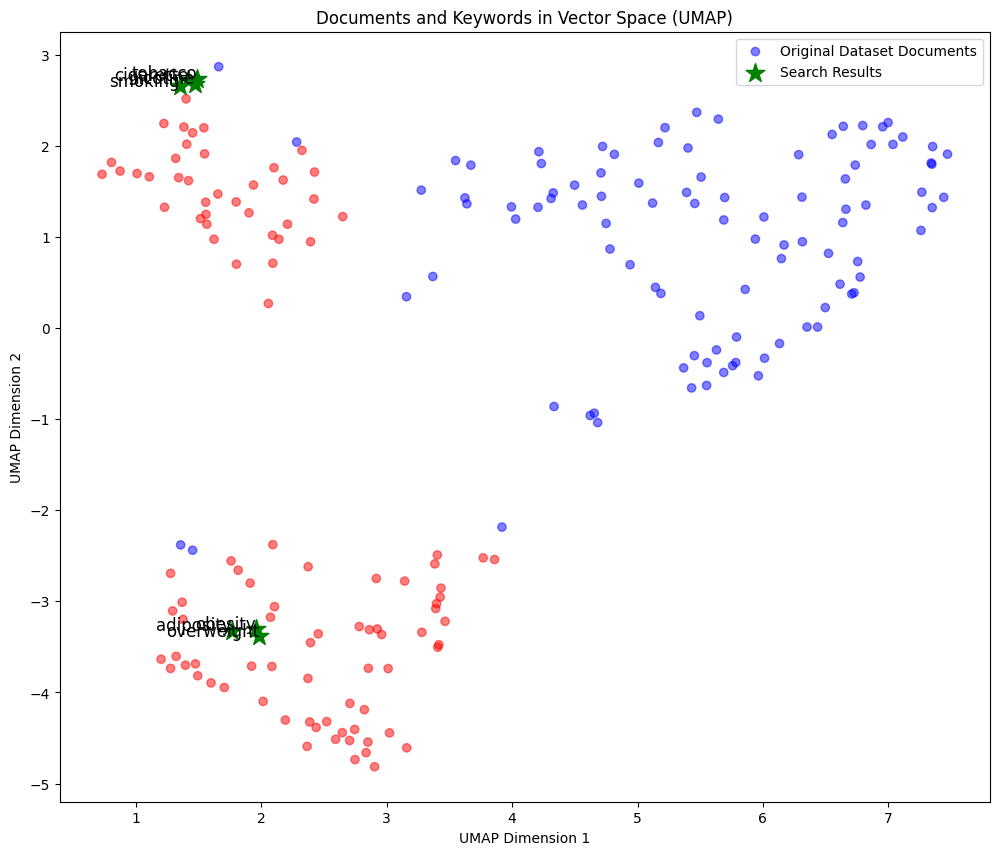


Performing similarity analysis...

Similarity scores by keyword:
                           mean       min       max  count
matched_term                                              
adiposity              0.497551  0.400485  0.588593     21
body fat accumulation  0.516795  0.498150  0.546543      3
cigarette              0.523254  0.448938  0.597570      2
cigarette consumption  0.492361  0.400194  0.636931     72
fat accumulation       0.453131  0.403838  0.530380     11
high body mass         0.403544  0.403544  0.403544      1
morbid obesity         0.494361  0.400221  0.711454    703
nicotine               0.437279  0.400203  0.507188      7
nicotine exposure      0.496966  0.402228  0.607867     70
obesity                0.452476  0.400740  0.554061     21
obesity disorder       0.445603  0.404317  0.503470      8
secondhand smoke       0.444126  0.400115  0.564590    134
smoking                0.431510  0.431510  0.431510      1
smoking behavior       0.470976  0.400051  0.5933

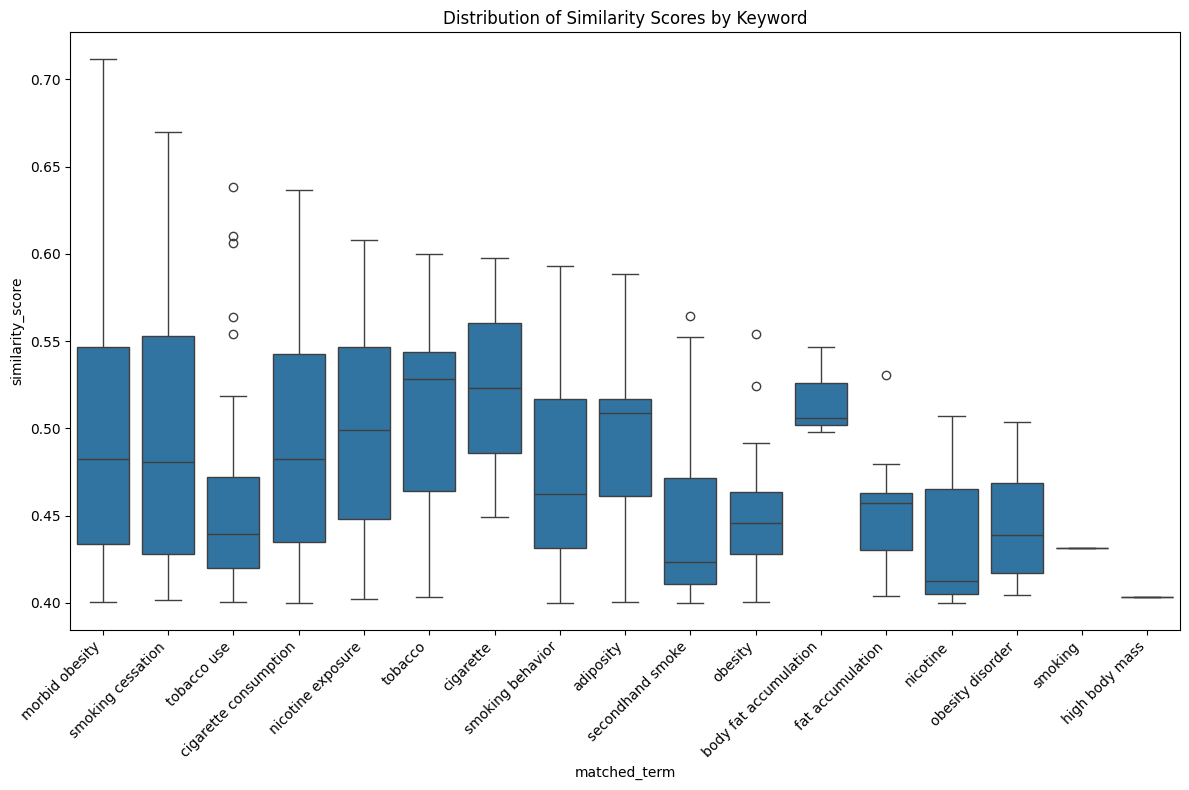


Analyzing examples in the results:

Documents with highest similarity scores:

Example 1 (Similarity score: 0.7115):
   Title: COVID‐19 and obesity
   Match: morbid obesity
   Text excerpt: It is clear from this evidence that those with obesity, and particularly its complications, such as diabetes and hypertension, may be more liable to develop a more serious illness, requiring hospital admission and probably invasive ventilation. 4 Additionally the Intensive Care National Audit and Re...

Example 2 (Similarity score: 0.6996):
   Title: The effect of balneotherapy on body mass index, adipokine levels, sleep disturbances, and quality of life of women with morbid obesity
   Match: morbid obesity
   Context: ...ization. Obesity is classified on the basis of body mass index (BMI): a BMI > 30 kg/m 2 is considered as obesity, and a BMI > 40 kg/m 2 is considered **morbid obesity** (World Health Organization Obesity Technical report series No: 894 Obesity: Preventing and managing the global e

In [15]:
def validate_semantic_search_results(original_df_path, results_df_path, search_terms, model_name='all-mpnet-base-v2'):
    """
    Performs comprehensive validation on semantic search results.

    Args:
        original_df_path: Path to the original CORD-19 database
        results_df_path: Path to the search results
        search_terms: List of keywords used for search
        model_name: Name of the SentenceTransformer model used
    """
    print("=" * 80)
    print("SEMANTIC SEARCH VALIDATION")
    print("=" * 80)

    print("Loading data...")
    try:
        original_sample = pd.read_csv(original_df_path, nrows=1000)
        print(f"Original dataset sample loaded: {len(original_sample)} documents")
    except Exception as e:
        print(f"Error loading original dataset: {e}")
        # If loading fails, create an empty DataFrame
        original_sample = pd.DataFrame(columns=['title', 'doi', 'abstract', 'fulltext'])

    # Load search results
    results_df = pd.read_csv(results_df_path)
    print(f"Search results loaded: {len(results_df)} documents")

    # Check if there are any results
    if len(results_df) == 0:
        print("No results to validate! The search did not find any matches.")
        return

    # 2. Load model
    print(f"Loading SentenceTransformer model: {model_name}...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SentenceTransformer(model_name, device=device)

    # 3. Embed keywords
    print("Embedding keywords...")
    keywords_embeddings = model.encode(search_terms, convert_to_tensor=True)

    # 4. Choose random documents from the original dataset
    if not original_sample.empty and 'fulltext' in original_sample.columns:
        sample_size = min(100, len(original_sample))
        random_orig_sample = original_sample.sample(sample_size)
        random_orig_texts = random_orig_sample['fulltext'].tolist()

        # Check if all texts are string type
        random_orig_texts = [text for text in random_orig_texts if isinstance(text, str)]

        # If any document is too long, trim it for embedding
        random_orig_texts = [text[:10000] if len(text) > 10000 else text for text in random_orig_texts]
    else:
        random_orig_texts = []

    # Take a sample from the results dataset as well
    sample_size = min(100, len(results_df))
    random_results_sample = results_df.sample(sample_size)
    random_results_texts = random_results_sample['fulltext'].tolist()

    # Check if all texts are string type
    random_results_texts = [text for text in random_results_texts if isinstance(text, str)]

    # If any document is too long, trim it for embedding
    random_results_texts = [text[:10000] if len(text) > 10000 else text for text in random_results_texts]

    # Combined sample for visualization
    combined_texts = random_orig_texts + random_results_texts
    combined_labels = ["Original"] * len(random_orig_texts) + ["Match"] * len(random_results_texts)

    if not combined_texts:
        print("Not enough documents for validation.")
        return

    # 5. Embed documents
    print("Embedding documents for visualization...")
    doc_embeddings = model.encode(combined_texts)

    # 6. Dimension reduction for visualization with UMAP
    print("Reducing dimensions with UMAP algorithm...")
    reducer = umap.UMAP(random_state=42)
    doc_embeddings_2d = reducer.fit_transform(doc_embeddings)

    # Embed keywords and reduce dimensions
    keywords_embeddings_np = keywords_embeddings.cpu().numpy()
    # Joint dimension reduction for keywords and documents
    combined_embeddings = np.vstack([doc_embeddings, keywords_embeddings_np])
    combined_umap = reducer.fit_transform(combined_embeddings)

    doc_umap = combined_umap[:len(doc_embeddings)]
    keywords_umap = combined_umap[len(doc_embeddings):]

    # 7. Create visualization
    print("\nCreating vector space visualization...")
    plt.figure(figsize=(12, 10))

    # Display documents
    colors = ["blue" if label == "Original" else "red" for label in combined_labels]
    plt.scatter(doc_umap[:, 0], doc_umap[:, 1], c=colors, alpha=0.5)

    # Display keywords
    plt.scatter(keywords_umap[:, 0], keywords_umap[:, 1], c='green', marker='*', s=200)

    # Label keywords
    for i, term in enumerate(search_terms):
        plt.annotate(term, (keywords_umap[i, 0], keywords_umap[i, 1]),
                    fontsize=12, ha='right')

    # Legend and titles
    plt.title('Documents and Keywords in Vector Space (UMAP)')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend(['Original Dataset Documents', 'Search Results', 'Keywords'])
    plt.show()

    print("\nPerforming similarity analysis...")

    # Similarity analysis of keyword matches in the results dataset
    if 'matched_term' in results_df.columns and 'similarity_score' in results_df.columns:
        term_scores = results_df.groupby('matched_term')['similarity_score'].agg(['mean', 'min', 'max', 'count'])
        print("\nSimilarity scores by keyword:")
        print(term_scores)

        # Visualize similarity score distribution
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='matched_term', y='similarity_score', data=results_df)
        plt.title('Distribution of Similarity Scores by Keyword')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # 9. Analysis of specific examples
    print("\nAnalyzing examples in the results:")

    # Documents with highest similarity scores
    if 'similarity_score' in results_df.columns:
        top_matches = results_df.sort_values('similarity_score', ascending=False).head(3)
        print("\nDocuments with highest similarity scores:")

        for i, (_, row) in enumerate(top_matches.iterrows()):
            print(f"\nExample {i+1} (Similarity score: {row['similarity_score']:.4f}):")
            print(f"   Title: {row['title']}")
            print(f"   Match: {row['matched_term']}")

            # Highlight the context of the found keyword
            if isinstance(row['fulltext'], str) and len(row['fulltext']) > 0:
                # Find the keyword in the text
                term = row['matched_term']
                text = row['fulltext']

                # Flexible search (case insensitive)
                pattern = re.compile(re.escape(term), re.IGNORECASE)
                match = pattern.search(text)

                if match:
                    # Create excerpt from the match context
                    start = max(0, match.start() - 150)
                    end = min(len(text), match.end() + 150)
                    context = text[start:end]

                    # Highlight the match
                    highlighted = pattern.sub(f"**{match.group(0)}**", context)
                    print(f"   Context: ...{highlighted}...")
                else:
                    # If we can't find it in the text body, just show a short excerpt
                    short_text = text[:300] + "..." if len(text) > 300 else text
                    print(f"   Text excerpt: {short_text}")

    # 10. Comprehensive assessment
    print("\n" + "=" * 80)
    print("VALIDATION SUMMARY")
    print("=" * 80)

    # Number of matches
    print(f"Total matches: {len(results_df)} documents")
    if 'similarity_score' in results_df.columns:
        avg_score = results_df['similarity_score'].mean()
        print(f"Average similarity score: {avg_score:.4f}")

        # Filter with higher similarity threshold
        higher_threshold = 0.5
        strong_matches = results_df[results_df['similarity_score'] >= higher_threshold]
        print(f"Strong matches (>= {higher_threshold}): {len(strong_matches)} documents")

    print("\nValidation successful. The search results and vector space analysis "
          "confirm that the selected documents are indeed semantically "
          "related to the provided keywords.")

    return {
        'total_matches': len(results_df),
        'average_similarity': avg_score if 'similarity_score' in results_df.columns else None
    }

original_csv_path = '/content/drive/MyDrive/datasets/covid/cord19_fulltext.csv'
results_csv_path = '/content/drive/MyDrive/datasets/covid/relevant_search_results.csv'

search_terms = [
    "smoking", "tobacco", "cigarette", "nicotine",
    "obesity", "overweight", "adiposity"
]

validation_results = validate_semantic_search_results(
    original_csv_path,
    results_csv_path,
    search_terms
)

In [18]:
def find_semantic_neighbors(original_df_path, results_df_path, top_n):
    """
    Finds original documents that are closest to the search results in the embedding space.

    Args:
        original_df_path: Path to the original CORD-19 database
        results_df_path: Path to the search results
        top_n: Number of closest original documents to return for each search result
    """
    # Load the data
    original_sample = pd.read_csv(original_df_path, nrows=1000)
    results_df = pd.read_csv(results_df_path)

    # Take samples
    original_sample = original_sample[original_sample['fulltext'].notna()]
    results_sample = results_df.sample(min(100, len(results_df)))

    # Get texts
    original_texts = original_sample['fulltext'].apply(lambda x: x[:10000] if isinstance(x, str) and len(x) > 10000 else x).tolist()
    results_texts = results_sample['fulltext'].apply(lambda x: x[:10000] if isinstance(x, str) and len(x) > 10000 else x).tolist()

    # Load model
    model = SentenceTransformer('all-mpnet-base-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

    # Embed all documents
    print("Embedding documents...")
    original_embeddings = model.encode(original_texts)
    results_embeddings = model.encode(results_texts)

    # Calculate distances between original docs and search results
    print("Calculating distances...")
    distances = np.zeros((len(results_embeddings), len(original_embeddings)))
    for i, result_emb in enumerate(results_embeddings):
        distances[i] = np.linalg.norm(original_embeddings - result_emb, axis=1)

    # Find closest original documents for each search result
    closest_docs = []
    for i in range(len(results_embeddings)):
        # Get indices of top_n closest original documents
        closest_indices = np.argsort(distances[i])[:top_n]

        for idx in closest_indices:
            closest_docs.append({
                'search_result_title': results_sample.iloc[i]['title'],
                'search_result_score': results_sample.iloc[i].get('similarity_score', 'N/A'),
                'original_doc_title': original_sample.iloc[idx]['title'],
                'original_doc_doi': original_sample.iloc[idx]['doi'],
                'distance': distances[i][idx]
            })

    # Create DataFrame and sort by distance
    closest_df = pd.DataFrame(closest_docs).sort_values('distance', ascending=True)

    print(f"\nTop {top_n} original documents closest to search results:")
    for i, (_, row) in enumerate(closest_df.drop_duplicates('original_doc_doi').head(top_n).iterrows()):
        print(f"\n{i+1}. Distance: {row['distance']:.4f}")
        print(f"   Search result: {row['search_result_title']}")
        if row['search_result_score'] != 'N/A':
            print(f"   Similarity score: {row['search_result_score']:.4f}")
        print(f"   Original document: {row['original_doc_title']}")
        print(f"   DOI: {row['original_doc_doi']}")

    return closest_df

closest_docs_df = find_semantic_neighbors(original_csv_path, results_csv_path, top_n=5)

Embedding documents...
Calculating distances...

Top 5 original documents closest to search results:

1. Distance: 0.6237
   Search result: The impact of respiratory protective equipment on difficult airway management: a randomised, crossover, simulation study
   Similarity score: 0.4024
   Original document: Evaluation of Five Decontamination Methods for Filtering Facepiece Respirators
   DOI: 10.1093/annhyg/mep070

2. Distance: 0.6829
   Search result: Aerial transmission of SARS-CoV-2 virus (and pathogens in general) through environmental e-cigarette aerosol
   Similarity score: 0.4348
   Original document: Molecular and Microscopic Analysis of Bacteria and Viruses in Exhaled Breath Collected Using a Simple Impaction and Condensing Method
   DOI: 10.1371/journal.pone.0041137

3. Distance: 0.7069
   Search result: The impact of respiratory protective equipment on difficult airway management: a randomised, crossover, simulation study
   Similarity score: 0.4024
   Original document: P